# 1 Overview volume timeseries plots (just for analysis)

---

In [1]:
DATE = 'Jun29'
# download it here https://cluster.klima.uni-bremen.de/~lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc
# and change the path to your local path

---

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
fill_option = 'repeat_last_20yrs'

try:
    path_merged_runs_scaled = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    path_merged_runs_scaled_extend = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled)

except:
    path_merged_runs_scaled = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    path_merged_runs_scaled_extend = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled)

#ds_reg_models = xr.open_dataset(path_merged_runs_scaled)
#ds_reg_models_w_runaway = xr.open_dataset(path_merged_runs_scaled_w_runaway).sel(model_author='OGGM_v16')

In [3]:
from help_func import pal_models, model_order, d_reg_num_name, model_order_anonymous
# remove OGGM_v153 and Huss
hue_order_anonymous = []
hue_order = model_order[:-2] 
models = hue_order 
pal_models = pal_models[:-2]
pal_models = sns.color_palette(pal_models)
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])

print(hue_order, hue_order_anonymous)
pal_models

['Rounce', 'Compagno', 'Zekollari', 'OGGM_v16', 'OGGM-VAS', 'GLIMB', 'Kraaijenbrink', 'James', 'CISM2'] ['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6', 'model 7', 'model 8', 'model 9']


[(0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744)]

In [4]:
dict_model_col = {}
for c,m in zip(pal_models, hue_order):
    dict_model_col[m] = c

In [5]:
# remove OGGM_v153 and Huss
ds_reg_models = ds_reg_models.sel(model_author = models)

In [6]:
# check if 0 removed from RGI region 17 , because there were some isssues in the GloGEM dataset 
ds_reg_models_sel = ds_reg_models.sel(rgi_reg='17')
assert len(ds_reg_models_sel.sel(simulation_year=2000).volume_m3.where(ds_reg_models_sel.sel(simulation_year=2000).volume_m3==0).dropna(dim='model_author', how='all').model_author) == 0
assert len(ds_reg_models_sel.sel(simulation_year=5000).volume_m3.where(ds_reg_models_sel.sel(simulation_year=5000).volume_m3==0).dropna(dim='model_author', how='all').model_author) == 0

## overview timeseries plots (just for analysis)

- time series for every experiment an other figure, another subplot for every region
- in every subplot: one RGI region, all the models and maybe all gcms?

In [7]:
plt.rc('font', size=20)     

In [8]:
rgi_regs = []
for rgi_reg in np.arange(1,20,1):
    if rgi_reg < 10:
        rgi_reg = '0'+str(rgi_reg)
    else:
        rgi_reg = str(rgi_reg)
    rgi_regs.append(rgi_reg)

In [9]:
ds_reg_models_stack = ds_reg_models.stack(exps =('gcm','rgi_reg',
                                                     'period_scenario', 'model_author'))
# test if all the experiments are unique
# for volume_m3
unq, count = np.unique(ds_reg_models_stack.volume_m3.values, axis=1, return_counts=True)
assert np.shape(ds_reg_models_stack.volume_m3.values) == np.shape(unq)
assert np.all(count==1)
# for area_m2
unq, count = np.unique(ds_reg_models_stack.area_m2.values, axis=1, return_counts=True)
assert np.shape(ds_reg_models_stack.area_m2.values) == np.shape(unq)
assert np.all(count==1)

### selected Fig. for manuscript:

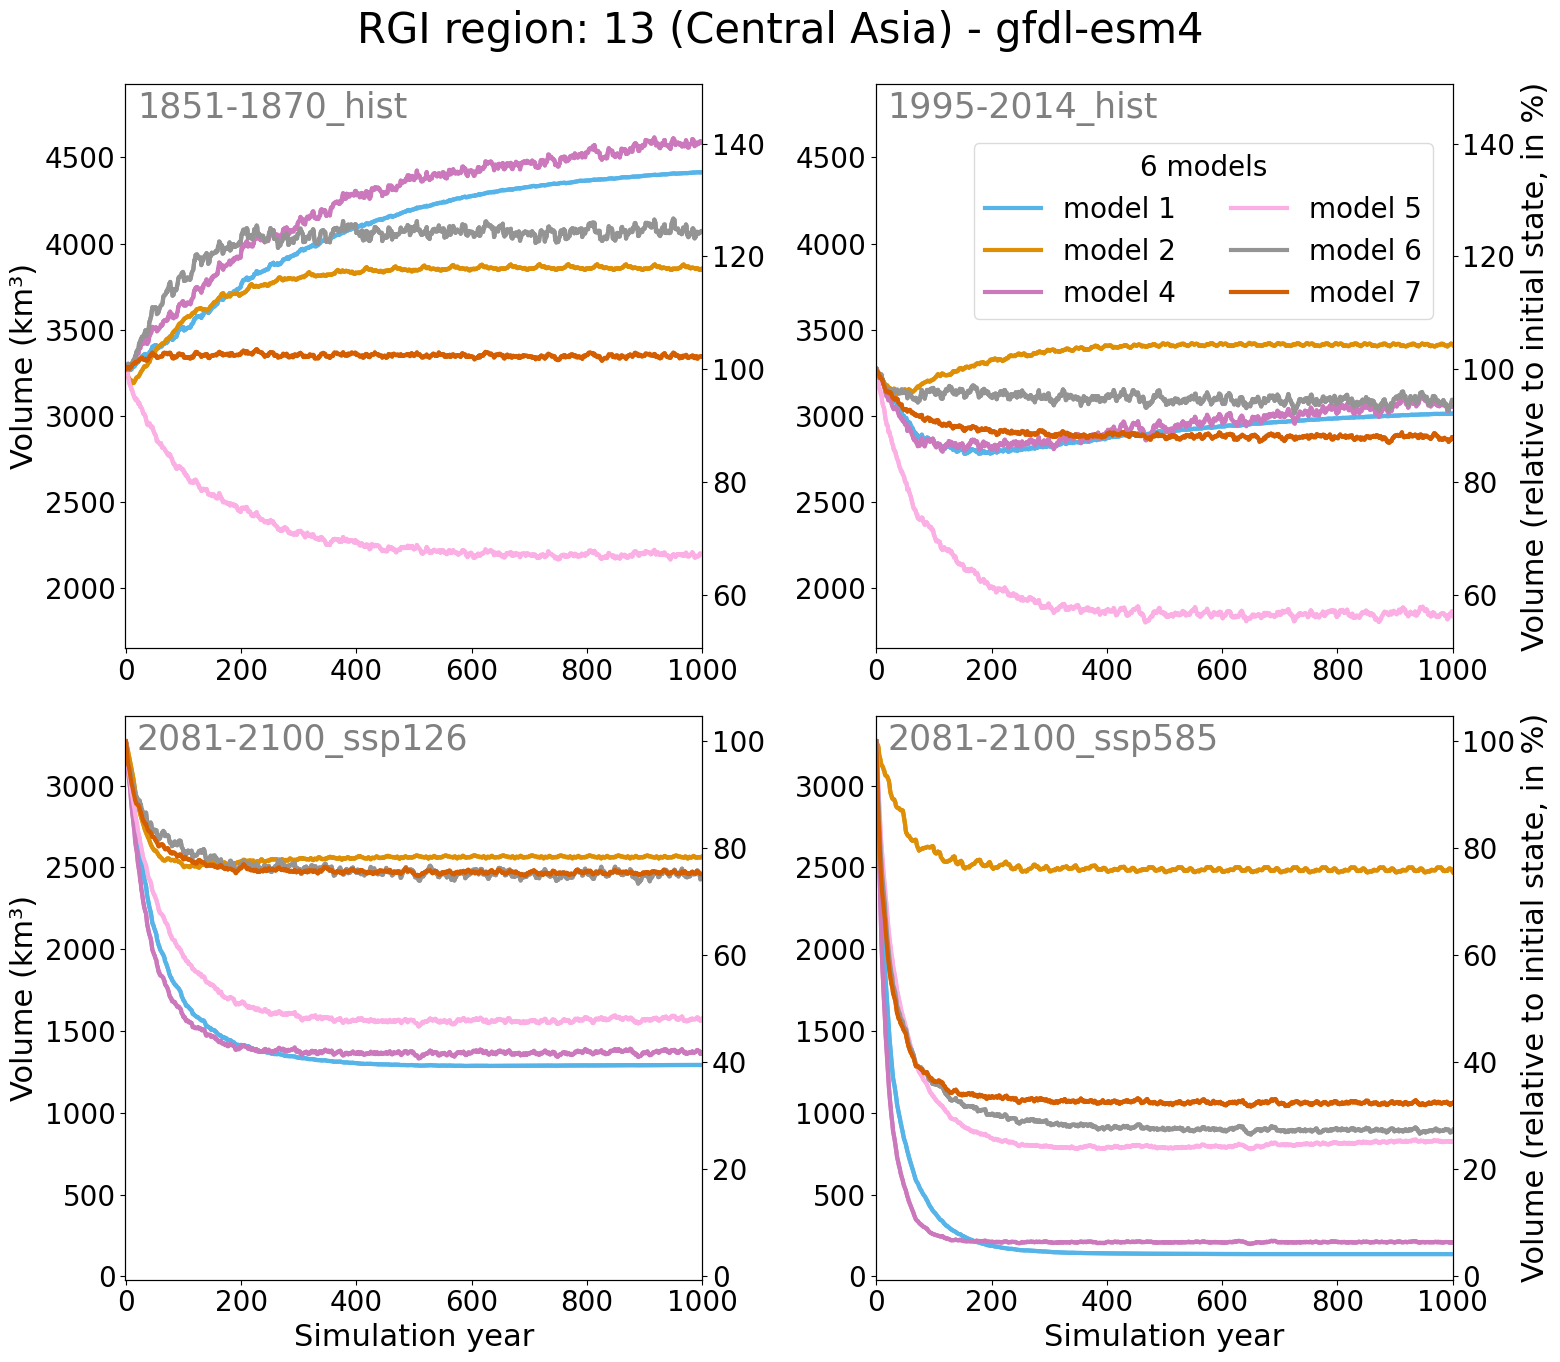

In [71]:
ls = 'solid'
sel_periods = ['1851-1870_hist','1995-2014_hist','2081-2100_ssp126','2081-2100_ssp585']
for anonym in ['_anonym']: #'', 
    for gcm in [ds_reg_models.gcm.values[0]]:
        #for rgi_reg in ['11']:
        for rgi_reg in ['13']:
            plt.figure(figsize=(16,14))
            axs = []
            for j,period_scenario in enumerate(sel_periods):
                if j==0 or j==2:
                    ax0=plt.subplot(2,2,j+1)
                    ax = ax0
                else:
                    ax=plt.subplot(2,2,j+1,sharey=ax0)
                axs.append(ax)
                
                pd_reg_vol_sel = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (km³)'] = pd_reg_vol_sel['volume_m3']/1e9
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)

                # add runaway effect
                #pd_reg_vol_sel_runaway_oggm = ds_reg_models_w_runaway.sel(period_scenario=period_scenario).sel(gcm=gcm).volume_m3.to_dataframe().reset_index()
                #pd_reg_vol_sel_runaway_oggm['volume (km³)'] = pd_reg_vol_sel_runaway_oggm['volume_m3']/1e9

                #sns.lineplot(x='simulation_year', data=pd_reg_vol_sel_runaway_oggm.loc[pd_reg_vol_sel_runaway_oggm.rgi_reg==rgi_reg], y='volume (km³)',
                #             color=dict_model_col['OGGM_v16'], ls='--', legend=False, lw=0.5, #ax=ax,
                #             alpha =1)

                if j in [0,2]:
                    plt.ylabel('Volume (km³)', fontsize=22)
                else:
                    plt.ylabel('')
                plt.xlabel('Simulation year', fontsize=22)

                ax.set_xlim([-1,1000])
                if j==1:
                    minip, maxip = ax.get_ylim()
                elif j==3:
                    minif, maxif = ax.get_ylim()



            for j,period_scenario in enumerate(sel_periods):
                ax = axs[j]
                ax2 = ax.twinx()
                
                sel_ds_reg_model_vol = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3
                _ref = 100*sel_ds_reg_model_vol/sel_ds_reg_model_vol.sel(simulation_year=0)
                pd_reg_vol_sel = _ref.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (relative to initial state, in %)'] = pd_reg_vol_sel['volume_m3']
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                # get  regional models and correct color, anonym model number 
                # to  get a legend with only the models of that region... 
                models_reg = pd_reg_vol_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                if ls == 'solid' and j==1:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax2)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax2)
            
                if j in [1,3]:
                    ax2.set_ylabel('Volume (relative to initial state, in %)', fontsize=22)
                    #ax.set_yticklabels([])
                else:
                    ax2.set_ylabel('')
                    #ax2.set_yticklabels([])

                if j==1: 
                    _leg = ax2.get_legend()
                    handles, labels = ax2.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax2.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7, ncol=2,
                                        bbox_to_anchor=(0.99,0.92))
                    else:
                        leg = ax2.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 5

                #leg.set_bbox_to_anchor([1,1])
                ax2.text(0.02,0.94, str(period_scenario), color='grey', 
                        fontsize=25, transform=ax2.transAxes, zorder=6)
                    

                rel = 100*1e9/sel_ds_reg_model_vol.sel(simulation_year=0)
                rel = rel.dropna(dim='model_author')
                np.testing.assert_allclose(rel[0], rel)
                rel = rel[0].values

                if j<2:
                    ax2.set_ylim([minip*rel,maxip*rel])
                    ax.set_xlabel('')
                else:
                    ax2.set_ylim([minif*rel,maxif*rel])

            reg = d_reg_num_name[rgi_reg]
            plt.suptitle(f'RGI region: {rgi_reg} ({reg}) - {gcm}', fontsize=30)
            plt.tight_layout()

            plt.savefig(f'figures/1_overview_timeseries_plots/gcm_separate_vol_time_series/sel_manuscript_vol_time_series_rgi_reg{rgi_reg}_{gcm}{anonym}.png')


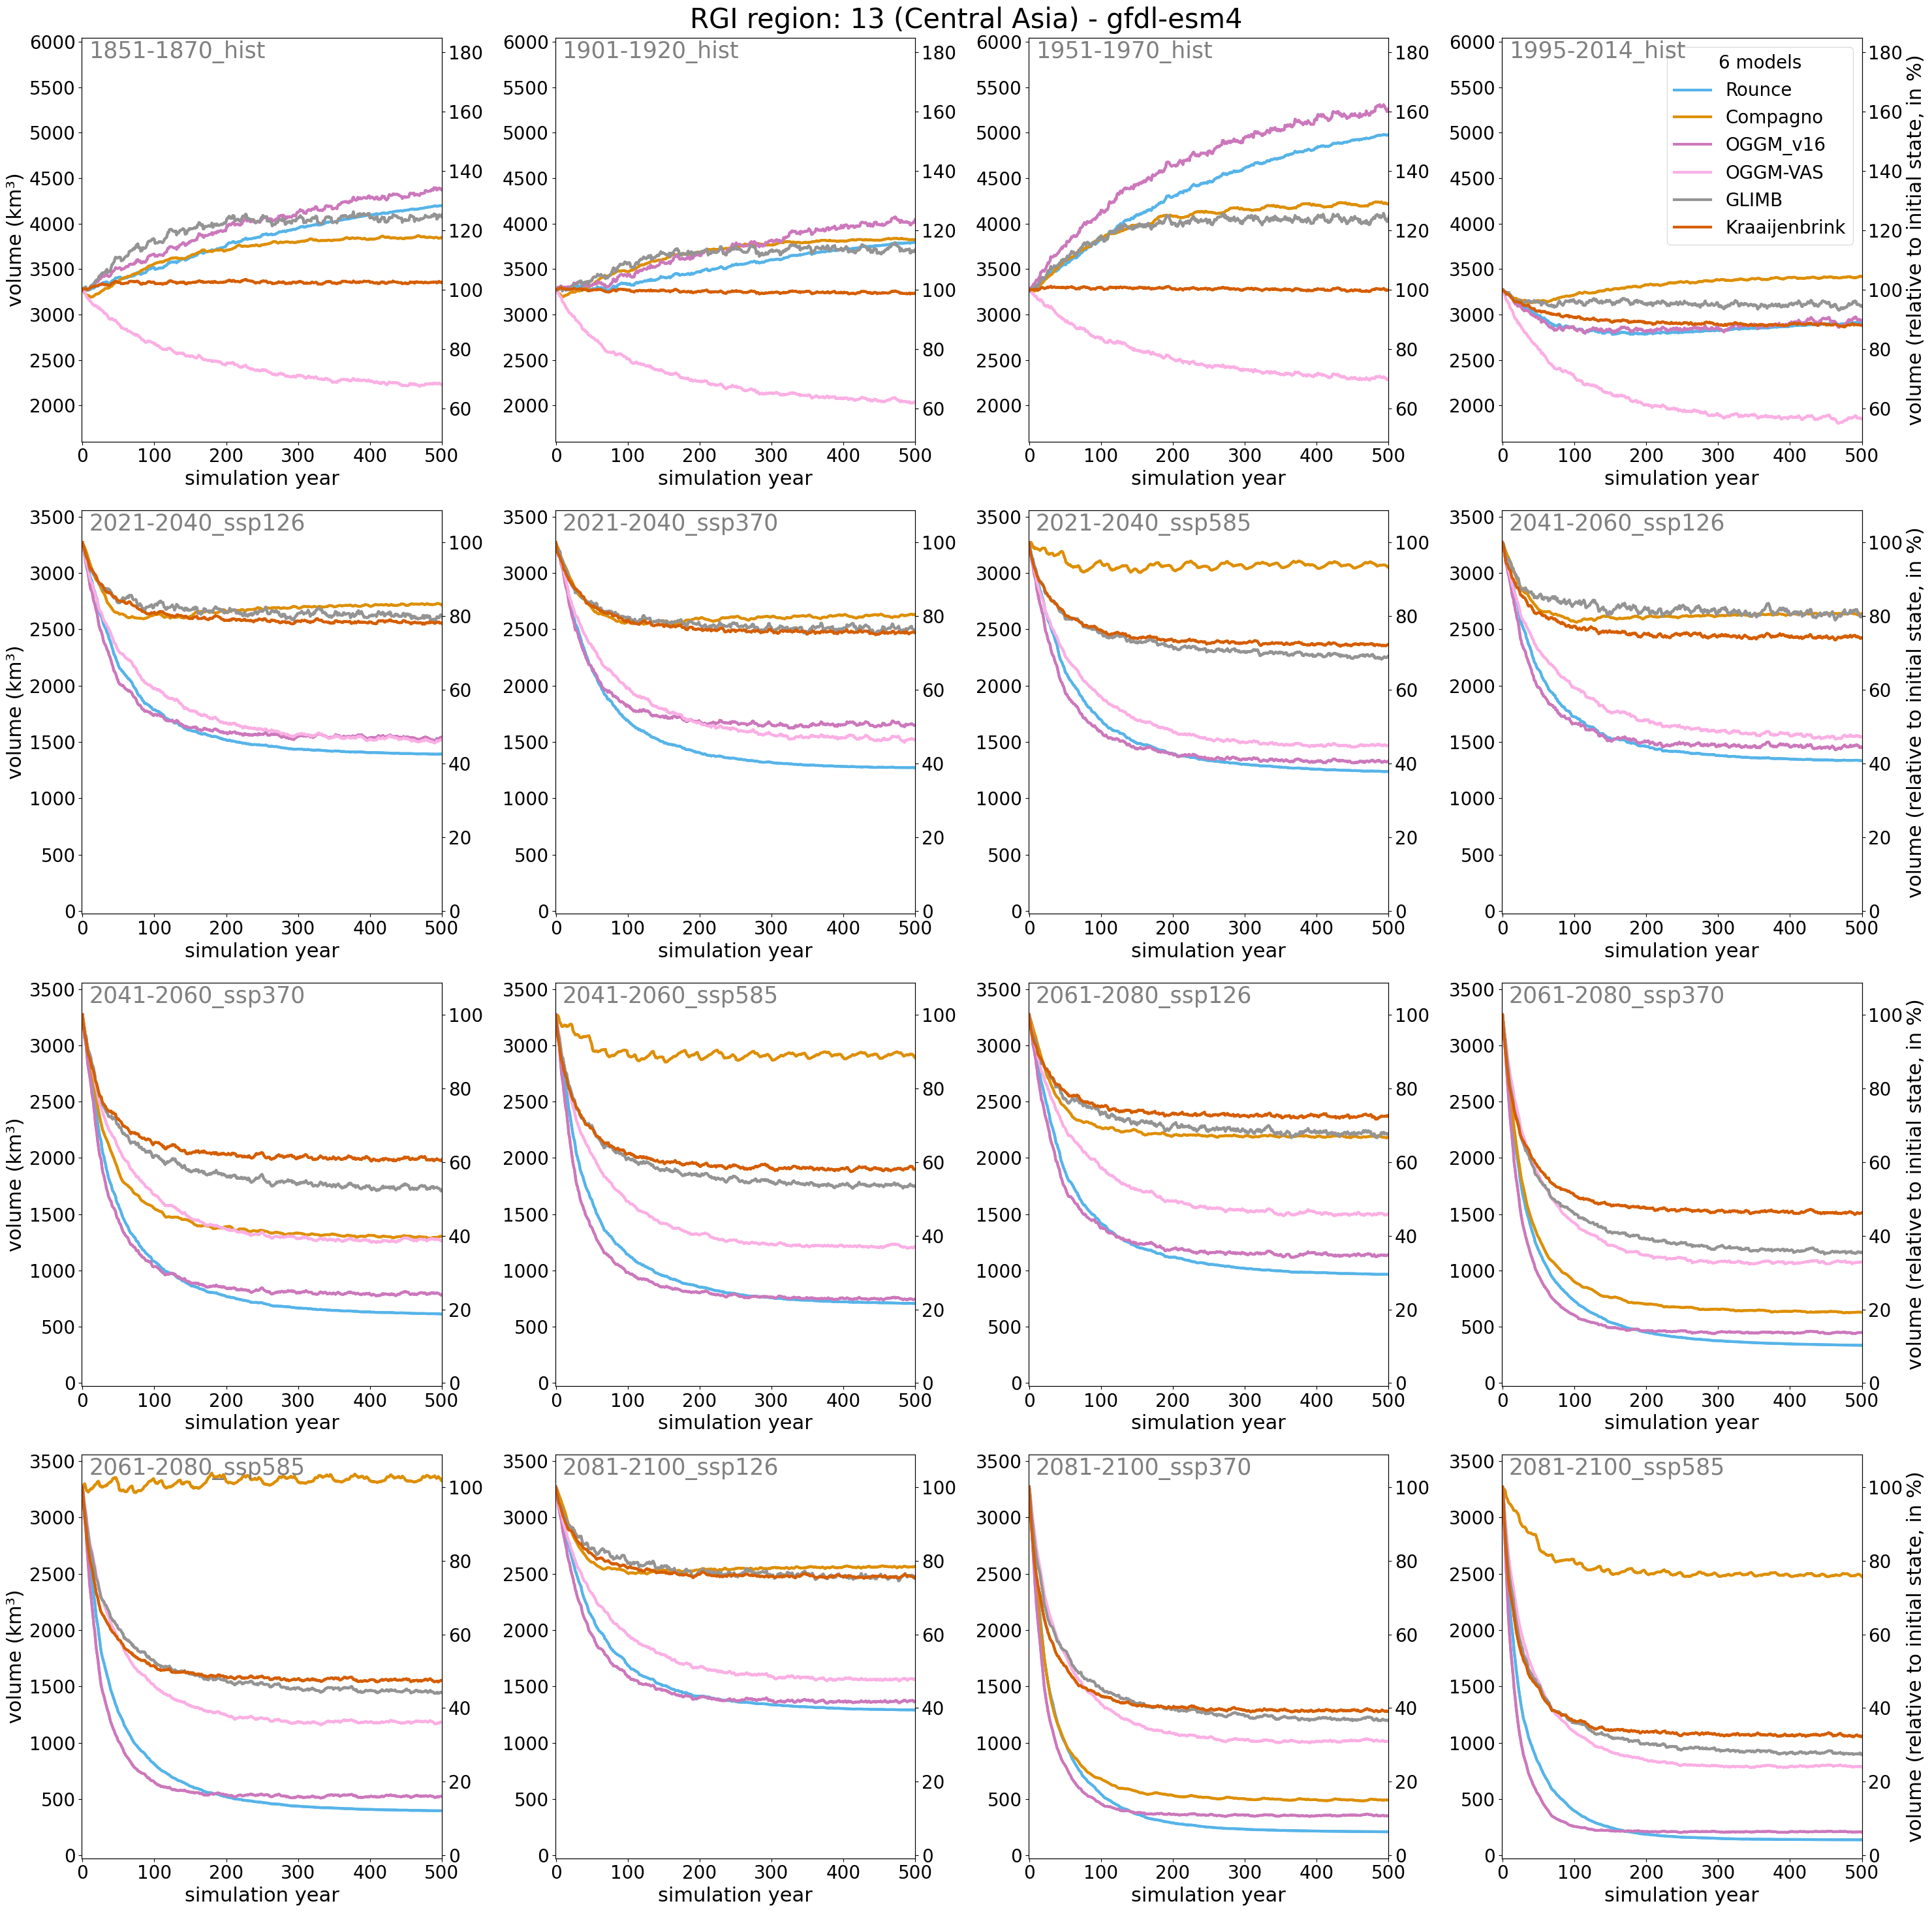

In [73]:
ls = 'solid'
for anonym in ['']: #'', 
    for gcm in [ds_reg_models.gcm.values[0]]:
        #for rgi_reg in ['11']:
        for rgi_reg in ['13']:
            plt.figure(figsize=(30,30))
            axs = []
            for j,period_scenario in enumerate(ds_reg_models.period_scenario):
                if j==0 or j==4:
                    ax0=plt.subplot(4,4,j+1)
                    ax = ax0
                else:
                    ax=plt.subplot(4,4,j+1,sharey=ax0)
                axs.append(ax)
                
                pd_reg_vol_sel = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (km³)'] = pd_reg_vol_sel['volume_m3']/1e9
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)

                # add runaway effect
                #pd_reg_vol_sel_runaway_oggm = ds_reg_models_w_runaway.sel(period_scenario=period_scenario).sel(gcm=gcm).volume_m3.to_dataframe().reset_index()
                #pd_reg_vol_sel_runaway_oggm['volume (km³)'] = pd_reg_vol_sel_runaway_oggm['volume_m3']/1e9

                #sns.lineplot(x='simulation_year', data=pd_reg_vol_sel_runaway_oggm.loc[pd_reg_vol_sel_runaway_oggm.rgi_reg==rgi_reg], y='volume (km³)',
                #             color=dict_model_col['OGGM_v16'], ls='--', legend=False, lw=0.5, #ax=ax,
                #             alpha =1)

                if j in [0,4,8,12]:
                    plt.ylabel('volume (km³)', fontsize=22)
                else:
                    plt.ylabel('')
                plt.xlabel('simulation year', fontsize=22)

                ax.set_xlim([-1,500])
                if j==3:
                    minip, maxip = ax.get_ylim()
                elif j==15:
                    minif, maxif = ax.get_ylim()



            for j,period_scenario in enumerate(ds_reg_models.period_scenario):
                ax = axs[j]
                ax2 = ax.twinx()
                
                sel_ds_reg_model_vol = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3
                _ref = 100*sel_ds_reg_model_vol/sel_ds_reg_model_vol.sel(simulation_year=0)
                pd_reg_vol_sel = _ref.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (relative to initial state, in %)'] = pd_reg_vol_sel['volume_m3']
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                # get  regional models and correct color, anonym model number 
                # to  get a legend with only the models of that region... 
                models_reg = pd_reg_vol_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax2)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax2)
            
                if j in [3,7,11,15]:
                    ax2.set_ylabel('volume (relative to initial state, in %)', fontsize=22)
                else:
                    ax2.set_ylabel('')

                    
                    
                if j==3: 
                    _leg = ax2.get_legend()
                    handles, labels = ax2.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax2.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7)
                    else:
                        leg = ax2.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 5


                #leg.set_bbox_to_anchor([1,1])
                ax2.text(0.02,0.95, str(period_scenario.values), color='grey', 
                        fontsize=25, transform=ax2.transAxes, zorder=6)

                rel = 100*1e9/sel_ds_reg_model_vol.sel(simulation_year=0)
                rel = rel.dropna(dim='model_author')
                np.testing.assert_allclose(rel[0], rel)
                rel = rel[0].values

                if j<4:
                    ax2.set_ylim([minip*rel,maxip*rel])
                else:
                    ax2.set_ylim([minif*rel,maxif*rel])

            reg = d_reg_num_name[rgi_reg]
            plt.suptitle(f'RGI region: {rgi_reg} ({reg}) - {gcm}', fontsize=30)
            plt.tight_layout()

            plt.savefig(f'figures/1_overview_timeseries_plots/gcm_separate_vol_time_series/manuscript_vol_time_series_rgi_reg{rgi_reg}_{gcm}{anonym}.png')


In [69]:
ls_l = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 1, 1, 1))]
for anonym in ['', '_anonym']:
    #for rgi_reg in ['11']:
    for rgi_reg in rgi_regs:

        axs = []
        plt.figure(figsize=(30,30))
        for j,period_scenario in enumerate(ds_reg_models.period_scenario):
            if j==0 or j==4:
                ax0=plt.subplot(4,4,j+1)
                ax = ax0
            else:
                ax=plt.subplot(4,4,j+1,sharey=ax0)
            axs.append(ax)
            for ls,gcm in zip(ls_l,ds_reg_models.gcm):
                pd_reg_vol_sel = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (km³)'] = pd_reg_vol_sel['volume_m3']/1e9

                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)
                if j in [0,4,8,12]:
                    ax.set_ylabel('volume (km³)', fontsize=22)
                else:
                    ax.set_ylabel('')
                ax.set_xlabel('simulation year', fontsize=22)


                        

                #leg.set_bbox_to_anchor([1,1])
            if j==3:
                minip, maxip = ax.get_ylim()
            elif j==15:
                minif, maxif = ax.get_ylim()

            ax.set_xlim([-100,5100])

        for j,period_scenario in enumerate(ds_reg_models.period_scenario):
            ax = axs[j]
            ax2 = ax.twinx()
            for ls,gcm in zip(ls_l,ds_reg_models.gcm):
                sel_ds_reg_model_vol = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3
                _ref = 100*sel_ds_reg_model_vol/sel_ds_reg_model_vol.sel(simulation_year=0)
                pd_reg_vol_sel = _ref.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (relative to initial state, in %)'] = pd_reg_vol_sel['volume_m3']
                
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                # get  regional models and correct color, anonym model number 
                # to  get a legend with only the models of that region... 
                models_reg = pd_reg_vol_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                        
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax2, zorder=2)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax2, zorder=2)
                if j in [3,7,11,15]:
                    ax2.set_ylabel('volume (relative to initial state, in %)', fontsize=22)
                else:
                    ax2.set_ylabel('')

                
                
                if ls == 'solid' and j==3: 
                    _leg = ax2.get_legend()
                    handles, labels = ax2.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax2.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7)
                    else:
                        leg = ax2.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 2.5
            
            
            rel = 100*1e9/sel_ds_reg_model_vol.sel(simulation_year=0)
            rel = rel.dropna(dim='model_author')
            np.testing.assert_allclose(rel[0], rel)
            rel = rel[0].values

            if j<4:
                ax2.set_ylim([minip*rel,maxip*rel])
            else:
                ax2.set_ylim([minif*rel,maxif*rel])
        
            ax2.text(0.02,0.95, str(period_scenario.values), color='grey', 
                    fontsize=25, transform=ax2.transAxes, zorder=6)

        reg = d_reg_num_name[rgi_reg]
        plt.suptitle(f'RGI region: {rgi_reg} ({reg})', fontsize=30)
        plt.tight_layout()

        plt.savefig(f'figures/1_overview_timeseries_plots/vol_time_series_rgi_reg{rgi_reg}{anonym}.png')
        plt.close()

- plots separately for every GCM:

In [ ]:
ls = 'solid'
for anonym in ['']: #, '_anonym']:
    for gcm in ds_reg_models.gcm.values:
        #for rgi_reg in ['11']:
        for rgi_reg in rgi_regs:
            plt.figure(figsize=(30,30))
            axs = []
            for j,period_scenario in enumerate(ds_reg_models.period_scenario):
                if j==0 or j==4:
                    ax0=plt.subplot(4,4,j+1)
                    ax = ax0
                else:
                    ax=plt.subplot(4,4,j+1,sharey=ax0)
                axs.append(ax)
                
                pd_reg_vol_sel = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (km³)'] = pd_reg_vol_sel['volume_m3']/1e9
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)

                # add runaway effect
                #pd_reg_vol_sel_runaway_oggm = ds_reg_models_w_runaway.sel(period_scenario=period_scenario).sel(gcm=gcm).volume_m3.to_dataframe().reset_index()
                #pd_reg_vol_sel_runaway_oggm['volume (km³)'] = pd_reg_vol_sel_runaway_oggm['volume_m3']/1e9

                #sns.lineplot(x='simulation_year', data=pd_reg_vol_sel_runaway_oggm.loc[pd_reg_vol_sel_runaway_oggm.rgi_reg==rgi_reg], y='volume (km³)',
                #             color=dict_model_col['OGGM_v16'], ls='--', legend=False, lw=0.5, #ax=ax,
                #             alpha =1)

                if j in [0,4,8,12]:
                    plt.ylabel('volume (km³)', fontsize=22)
                else:
                    plt.ylabel('')
                plt.xlabel('simulation year', fontsize=22)

                ax.set_xlim([-100,2000])
                if j==3:
                    minip, maxip = ax.get_ylim()
                elif j==15:
                    minif, maxif = ax.get_ylim()



            for j,period_scenario in enumerate(ds_reg_models.period_scenario):
                ax = axs[j]
                ax2 = ax.twinx()
                
                sel_ds_reg_model_vol = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3
                _ref = 100*sel_ds_reg_model_vol/sel_ds_reg_model_vol.sel(simulation_year=0)
                pd_reg_vol_sel = _ref.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (relative to initial state, in %)'] = pd_reg_vol_sel['volume_m3']
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                # get  regional models and correct color, anonym model number 
                # to  get a legend with only the models of that region... 
                models_reg = pd_reg_vol_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax2)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax2)
            
                if j in [3,7,11,15]:
                    ax2.set_ylabel('volume (relative to initial state, in %)', fontsize=22)
                else:
                    ax2.set_ylabel('')

                    
                    
                if j==3: 
                    _leg = ax2.get_legend()
                    handles, labels = ax2.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax2.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7)
                    else:
                        leg = ax2.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 5


                #leg.set_bbox_to_anchor([1,1])
                ax2.text(0.02,0.95, str(period_scenario.values), color='grey', 
                        fontsize=25, transform=ax2.transAxes, zorder=6)
                    
                rel = 100*1e9/sel_ds_reg_model_vol.sel(simulation_year=0)
                rel = rel.dropna(dim='model_author')
                np.testing.assert_allclose(rel[0], rel)
                rel = rel[0].values

                if j<4:
                    ax2.set_ylim([minip*rel,maxip*rel])
                else:
                    ax2.set_ylim([minif*rel,maxif*rel])
                if j<12:
                    ax.set_xlabel('')
            reg = d_reg_num_name[rgi_reg]
            plt.suptitle(f'RGI region: {rgi_reg} ({reg}) - {gcm}', fontsize=30)
            plt.tight_layout()

            plt.savefig(f'figures/1_overview_timeseries_plots/gcm_separate_vol_time_series/vol_time_series_rgi_reg{rgi_reg}_{gcm}{anonym}.png')
            plt.close()

### Plot the thinning rates (kg m-2 yr-1)
- what should be done if the glacier regions is almost gone (should a MB estimate still be estimated??

In [55]:
# thinning rate: 
# 
init_area = ds_reg_models.area_m2.sel(simulation_year=0)
deltaV = ds_reg_models.volume_m3.sel(simulation_year=slice(1,5000))-ds_reg_models.volume_m3.sel(simulation_year=slice(0,4999)).values
Aavg = 0.5* (ds_reg_models.area_m2.sel(simulation_year=slice(1,5000))+ds_reg_models.area_m2.sel(simulation_year=slice(0,4999)).values)
Aavg = Aavg.where(Aavg/init_area>0.005)# only compute thtat if region has above 0.5% of initial area (otherwise we get too much noise ... )
ds_specific_mb = deltaV/Aavg # m w.e. (kg m-2 yr-1), Attention we do not want to divide through zero 
ds_specific_mb_roll = ds_specific_mb.rolling(simulation_year=20, center=True).mean()
ds_specific_mb_roll

<xarray.DataArray (model_author: 9, gcm: 5, rgi_reg: 19, simulation_year: 5000,
                   period_scenario: 16)>
array([[[[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
...
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]]]], dtype=float32)
Coordinates:
  * model_author     (model_author) object 'Rounce' 'Compagno' ... 'CISM2'
  * simulation_year  (simulation_year) int16 1 2 3 4 5 ... 4997 4998 4999 5000
  * gcm              (gcm) object 'gfdl-esm4' 'ipsl-cm6a-lr' ... 'ukesm1-0-ll'
  * rgi_reg          (rgi_reg) object '01' '02' '03' '04' ... '17' '18' '19'
  * period_scenario  (period_scenario) object '1851-1870_hist' ... '2081-2100...

***Manuscript***

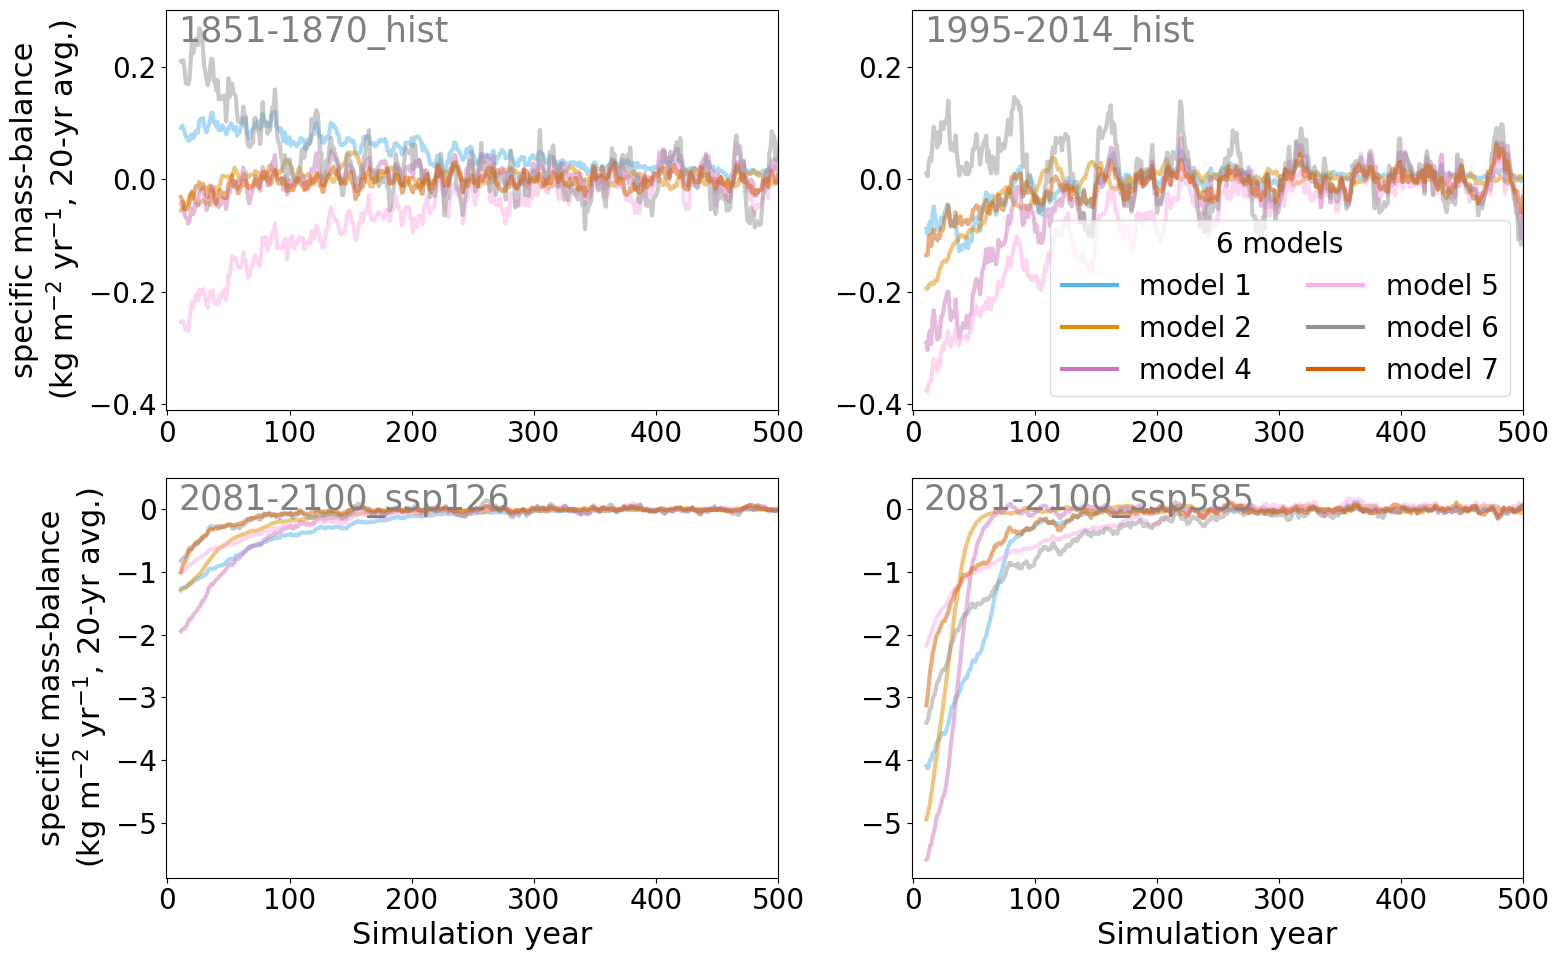

In [66]:
ls_l = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 1, 1, 1))]
for anonym in ['_anonym']:
    #for rgi_reg in ['11']:
    for rgi_reg in ['13']:

        axs = []
        plt.figure(figsize=(16,10))
        for j,period_scenario in enumerate(sel_periods):
            if j==0 or j==2:
                ax0=plt.subplot(2,2,j+1)
                ax = ax0
            else:
                ax=plt.subplot(2,2,j+1,sharey=ax0)
            axs.append(ax)
            for ls,gcm in zip([ls_l[0]],[ds_specific_mb.gcm[-1]]):
                pd_reg_spec_mb_sel = ds_specific_mb_roll.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).to_dataframe('specific_mb').reset_index()
                pd_reg_spec_mb_sel = pd_reg_spec_mb_sel.dropna()
                
                # get  regional models and correct color, anonym model number 
                # to  get a legend with only the models of that region... 
                models_reg = pd_reg_spec_mb_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                
                if ls == 'solid' and j==1:
                    sns.lineplot(x='simulation_year', data=pd_reg_spec_mb_sel, y='specific_mb',
                             hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax, alpha = 0.5)
                    _leg = ax.get_legend()
                    handles, labels = ax.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='lower right', framealpha = 0.7, ncol=2)
                    else:
                        leg = ax.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 2.5
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_spec_mb_sel, y='specific_mb',
                             hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax, alpha = 0.5)
                if j in [0,2]:
                    ax.set_ylabel('specific mass-balance\n'+r'(kg m$^{-2}$ yr$^{-1}$, 20-yr avg.)', fontsize=22)
                else:
                    ax.set_ylabel('')
                if j<2:
                    ax.set_xlabel('')
                else:
                    ax.set_xlabel('Simulation year', fontsize=22)


            minip, maxip = ax.get_ylim()

            ax.set_xlim([-1,500])            

            #if j<4:
            #    ax2.set_ylim([minip*rel,maxip*rel])
            #else:
            #    ax2.set_ylim([minif*rel,maxif*rel])
        
            ax.text(0.02,0.92, str(period_scenario), color='grey', 
                    fontsize=25, transform=ax.transAxes, zorder=6)

        reg = d_reg_num_name[rgi_reg]
        #plt.suptitle(f'RGI region: {rgi_reg} ({reg})', fontsize=30)
        plt.tight_layout()

        plt.savefig(f'figures/1_overview_timeseries_plots/manuscript_spec_mb_time_series_rgi_reg{rgi_reg}{anonym}_only_{gcm}.png')


- just check the last year:

In [147]:
pd_specific_mb_roll = ds_specific_mb_roll.dropna(dim='simulation_year', how='all').isel(simulation_year=-1).to_dataframe('specific_mb')

In [148]:
pd_specific_mb_roll_t = pd_specific_mb_roll.reset_index().groupby(['model_author', 'period_scenario']).median().dropna()

In [149]:
pd_specific_mb_roll.loc[np.abs(pd_specific_mb_roll.specific_mb)>0.01].reset_index().groupby('model_author').count()

,gcm,rgi_reg,period_scenario,simulation_year,specific_mb
model_author,,,,,
Compagno,172,172,172,172,172
GLIMB,77,77,77,77,77
James,57,57,57,57,57
OGGM-VAS,218,218,218,218,218
OGGM_v16,138,138,138,138,138
Rounce,77,77,77,77,77


- now check the average specific MB over 500 years, is it near zero?
    - RGI08: Zekollari, ipsl-cm6a-lr (2081-2100_ssp370, 2081-2100_ssp585) and ukesm1-0-ll (2041-2060_ssp370)-> there is sth. strange!!!

In [150]:
pd_specific_mb_roll_mean= ds_specific_mb_roll.dropna(dim='simulation_year', how='all').sel(simulation_year=slice(1450,1950)).mean(dim='simulation_year').to_dataframe('specific_mb_mean_100yr_avg')

In [151]:
pd_specific_mb_roll_mean = pd_specific_mb_roll_mean.dropna()

In [152]:
pd_specific_mb_roll_mean.loc[np.abs(pd_specific_mb_roll_mean.specific_mb_mean_100yr_avg)>0.01].reset_index().groupby('model_author').count().sort_values(by='specific_mb_mean_100yr_avg')

,gcm,rgi_reg,period_scenario,specific_mb_mean_100yr_avg
model_author,,,,
Zekollari,14,14,14,14
OGGM-VAS,112,112,112,112
Compagno,209,209,209,209
Rounce,283,283,283,283
GLIMB,449,449,449,449
OGGM_v16,562,562,562,562


In [153]:
pd_specific_mb_roll_mean.loc[np.abs(pd_specific_mb_roll_mean.specific_mb_mean_100yr_avg)>0.01].reset_index().groupby(['model_author']).max()#.#sort_values(by='specific_mb_mean_100yr_avg')

,gcm,rgi_reg,period_scenario,specific_mb_mean_100yr_avg
model_author,,,,
Compagno,ukesm1-0-ll,19,2081-2100_ssp585,0.162207
GLIMB,ukesm1-0-ll,19,2081-2100_ssp585,-0.010016
OGGM-VAS,ukesm1-0-ll,18,2081-2100_ssp585,0.081617
OGGM_v16,ukesm1-0-ll,19,2081-2100_ssp585,0.090120
Rounce,ukesm1-0-ll,19,2081-2100_ssp585,0.082060
Zekollari,ukesm1-0-ll,18,2081-2100_ssp585,0.807498


In [157]:
pd_specific_mb_roll_mean.loc[np.abs(pd_specific_mb_roll_mean.specific_mb_mean_100yr_avg)>0.2]#.#sort_values(by='specific_mb_mean_100yr_avg')

specific_mb_mean_100yr_avg
model_author gcm           rgi_reg period_scenario                             
Zekollari    mri-esm2-0    08      2041-2060_ssp126                    0.807498
OGGM_v16     mpi-esm1-2-hr 08      2061-2080_ssp370                   -0.234773
GLIMB        gfdl-esm4     09      2041-2060_ssp370                   -0.264262
                                   2041-2060_ssp585                   -0.238884
                                   2061-2080_ssp126                   -0.206358
             ipsl-cm6a-lr  09      2041-2060_ssp126                   -0.528460
                                   2081-2100_ssp126                   -0.490451
             mpi-esm1-2-hr 09      2041-2060_ssp370                   -0.244066
                                   2061-2080_ssp370                   -0.353979
                                   2061-2080_ssp585                   -0.350478
             mri-esm2-0    09      2021-2040_ssp585                   -0.234330
                                   2041-2060_ssp126                   -0.298733
                                   2041-2060_ssp370                   -0.399823
                                   2061-2080_ssp126                   -0.449704
             ukesm1-0-ll   09      2021-2040_ssp126                   -0.327903
                                   2021-2040_ssp585                   -0.472068

In [158]:
pd_specific_mb_roll_std = ds_specific_mb_roll.dropna(dim='simulation_year', how='all').sel(simulation_year=slice(1450,1950)).std(dim='simulation_year').to_dataframe('specific_mb_std_100yr_avg')

 is there a pattern in which models wobble around and which not??? I checked the standard deviation of the 100 yr average specific MB for the last 500 yrs... 
 - the largest std. of specific MB occur  for the models: James, GLIMB, OGGM-VAS, but there is some variability also in OGGM_v16 and CI

In [159]:
pd_specific_mb_roll_std.loc[np.abs(pd_specific_mb_roll_std.specific_mb_std_100yr_avg)>0.01].reset_index().groupby('model_author').max().sort_values(by='specific_mb_std_100yr_avg')

,gcm,rgi_reg,period_scenario,specific_mb_std_100yr_avg
model_author,,,,
Kraaijenbrink,ukesm1-0-ll,15,2081-2100_ssp585,0.018926
CISM2,ukesm1-0-ll,11,2081-2100_ssp585,0.024595
Rounce,ukesm1-0-ll,19,2081-2100_ssp585,0.028411
Compagno,ukesm1-0-ll,19,2081-2100_ssp585,0.036873
GLIMB,ukesm1-0-ll,19,2081-2100_ssp585,0.039583
OGGM_v16,ukesm1-0-ll,19,2081-2100_ssp585,0.040370
OGGM-VAS,ukesm1-0-ll,18,2081-2100_ssp585,0.069099
James,ukesm1-0-ll,06,2081-2100_ssp585,0.129646


In [162]:
pd_specific_mb_roll_std.loc[np.abs(pd_specific_mb_roll_std.specific_mb_std_100yr_avg)>0.03].reset_index().groupby('model_author').count()

,gcm,rgi_reg,period_scenario,specific_mb_std_100yr_avg
model_author,,,,
Compagno,1,1,1,1
GLIMB,28,28,28,28
James,76,76,76,76
OGGM-VAS,179,179,179,179
OGGM_v16,27,27,27,27


In [165]:
pd_specific_mb_roll_std.loc[np.abs(pd_specific_mb_roll_std.specific_mb_std_100yr_avg)>0.1]

specific_mb_std_100yr_avg
model_author gcm          rgi_reg period_scenario                            
James        ipsl-cm6a-lr 06      2041-2060_ssp585                   0.103562
                                  2061-2080_ssp585                   0.129646
                                  2081-2100_ssp585                   0.107311
             ukesm1-0-ll  06      1995-2014_hist                     0.110533
                                  2021-2040_ssp126                   0.106196

In [166]:
pd_specific_mb_roll_std.loc[np.abs(pd_specific_mb_roll_std.specific_mb_std_100yr_avg)>0.01].reset_index().groupby('model_author').count().sort_values(by='specific_mb_std_100yr_avg')

,gcm,rgi_reg,period_scenario,specific_mb_std_100yr_avg
model_author,,,,
Compagno,25,25,25,25
Kraaijenbrink,47,47,47,47
Rounce,47,47,47,47
CISM2,64,64,64,64
James,76,76,76,76
GLIMB,795,795,795,795
OGGM-VAS,829,829,829,829
OGGM_v16,903,903,903,903


In [168]:
t = pd_specific_mb_roll_std.reset_index().dropna()
t.loc[t.model_author=='CISM2'].max()

model_author                            CISM2
gcm                               ukesm1-0-ll
rgi_reg                                    11
period_scenario              2081-2100_ssp585
specific_mb_std_100yr_avg            0.024595
dtype: object

In [ ]:
ls_l = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 1, 1, 1))]
for anonym in ['', '_anonym']:
    #for rgi_reg in ['11']:
    for rgi_reg in rgi_regs:

        axs = []
        plt.figure(figsize=(30,30))
        for j,period_scenario in enumerate(ds_specific_mb.period_scenario):
            if j==0 or j==4:
                ax0=plt.subplot(4,4,j+1)
                ax = ax0
            else:
                ax=plt.subplot(4,4,j+1,sharey=ax0)
            axs.append(ax)
            for ls,gcm in zip(ls_l,ds_specific_mb.gcm):
                pd_reg_spec_mb_sel = ds_specific_mb_roll.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).to_dataframe('specific_mb').reset_index()
                pd_reg_spec_mb_sel = pd_reg_spec_mb_sel.dropna()
                
                # get  regional models and correct color, anonym model number 
                # to  get a legend with only the models of that region... 
                models_reg = pd_reg_spec_mb_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_spec_mb_sel, y='specific_mb',
                             hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax, alpha = 0.5)
                    _leg = ax.get_legend()
                    handles, labels = ax.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7)
                    else:
                        leg = ax.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 2.5
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_spec_mb_sel, y='specific_mb',
                             hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax, alpha = 0.5)
                if j in [0,4,8,12]:
                    ax.set_ylabel('specific mass-balance (100-yr avg.)', fontsize=22)
                else:
                    ax.set_ylabel('')
                ax.set_xlabel('simulation year', fontsize=22)


            if j==3:
                minip, maxip = ax.get_ylim()
            elif j==15:
                minif, maxif = ax.get_ylim()

            ax.set_xlim([-100,5100])            

            #if j<4:
            #    ax2.set_ylim([minip*rel,maxip*rel])
            #else:
            #    ax2.set_ylim([minif*rel,maxif*rel])
        
            ax.text(0.02,0.95, str(period_scenario.values), color='grey', 
                    fontsize=25, transform=ax.transAxes, zorder=6)

        reg = d_reg_num_name[rgi_reg]
        plt.suptitle(f'RGI region: {rgi_reg} ({reg})', fontsize=30)
        plt.tight_layout()

        plt.savefig(f'figures/1_overview_timeseries_plots/spec_mb_time_series_rgi_reg{rgi_reg}{anonym}.png')
        plt.close()

In [180]:
ls_l = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 1, 1, 1))]
for anonym in ['', '_anonym']:
    #for rgi_reg in ['11']:
    for rgi_reg in rgi_regs:

        axs = []
        plt.figure(figsize=(30,30))
        for j,period_scenario in enumerate(ds_specific_mb.period_scenario):
            if j==0 or j==4:
                ax0=plt.subplot(4,4,j+1)
                ax = ax0
            else:
                ax=plt.subplot(4,4,j+1,sharey=ax0)
            axs.append(ax)
            for ls,gcm in zip([ls_l[0]],[ds_specific_mb.gcm[0]]):
                pd_reg_spec_mb_sel = ds_specific_mb_roll.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).to_dataframe('specific_mb').reset_index()
                pd_reg_spec_mb_sel = pd_reg_spec_mb_sel.dropna()
                
                # get  regional models and correct color, anonym model number 
                # to  get a legend with only the models of that region... 
                models_reg = pd_reg_spec_mb_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_spec_mb_sel, y='specific_mb',
                             hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax, alpha = 0.5)
                    _leg = ax.get_legend()
                    handles, labels = ax.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7)
                    else:
                        leg = ax.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 2.5
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_spec_mb_sel, y='specific_mb',
                             hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax, alpha = 0.5)
                if j in [0,4,8,12]:
                    ax.set_ylabel('specific mass-balance (100-yr avg.)', fontsize=22)
                else:
                    ax.set_ylabel('')
                ax.set_xlabel('simulation year', fontsize=22)


            if j==3:
                minip, maxip = ax.get_ylim()
            elif j==15:
                minif, maxif = ax.get_ylim()

            ax.set_xlim([-100,5100])            

            #if j<4:
            #    ax2.set_ylim([minip*rel,maxip*rel])
            #else:
            #    ax2.set_ylim([minif*rel,maxif*rel])
        
            ax.text(0.02,0.95, str(period_scenario.values), color='grey', 
                    fontsize=25, transform=ax.transAxes, zorder=6)

        reg = d_reg_num_name[rgi_reg]
        plt.suptitle(f'RGI region: {rgi_reg} ({reg})', fontsize=30)
        plt.tight_layout()

        plt.savefig(f'figures/1_overview_timeseries_plots/spec_mb_time_series_rgi_reg{rgi_reg}{anonym}_only_gfdl-esm4.png')
        plt.close()

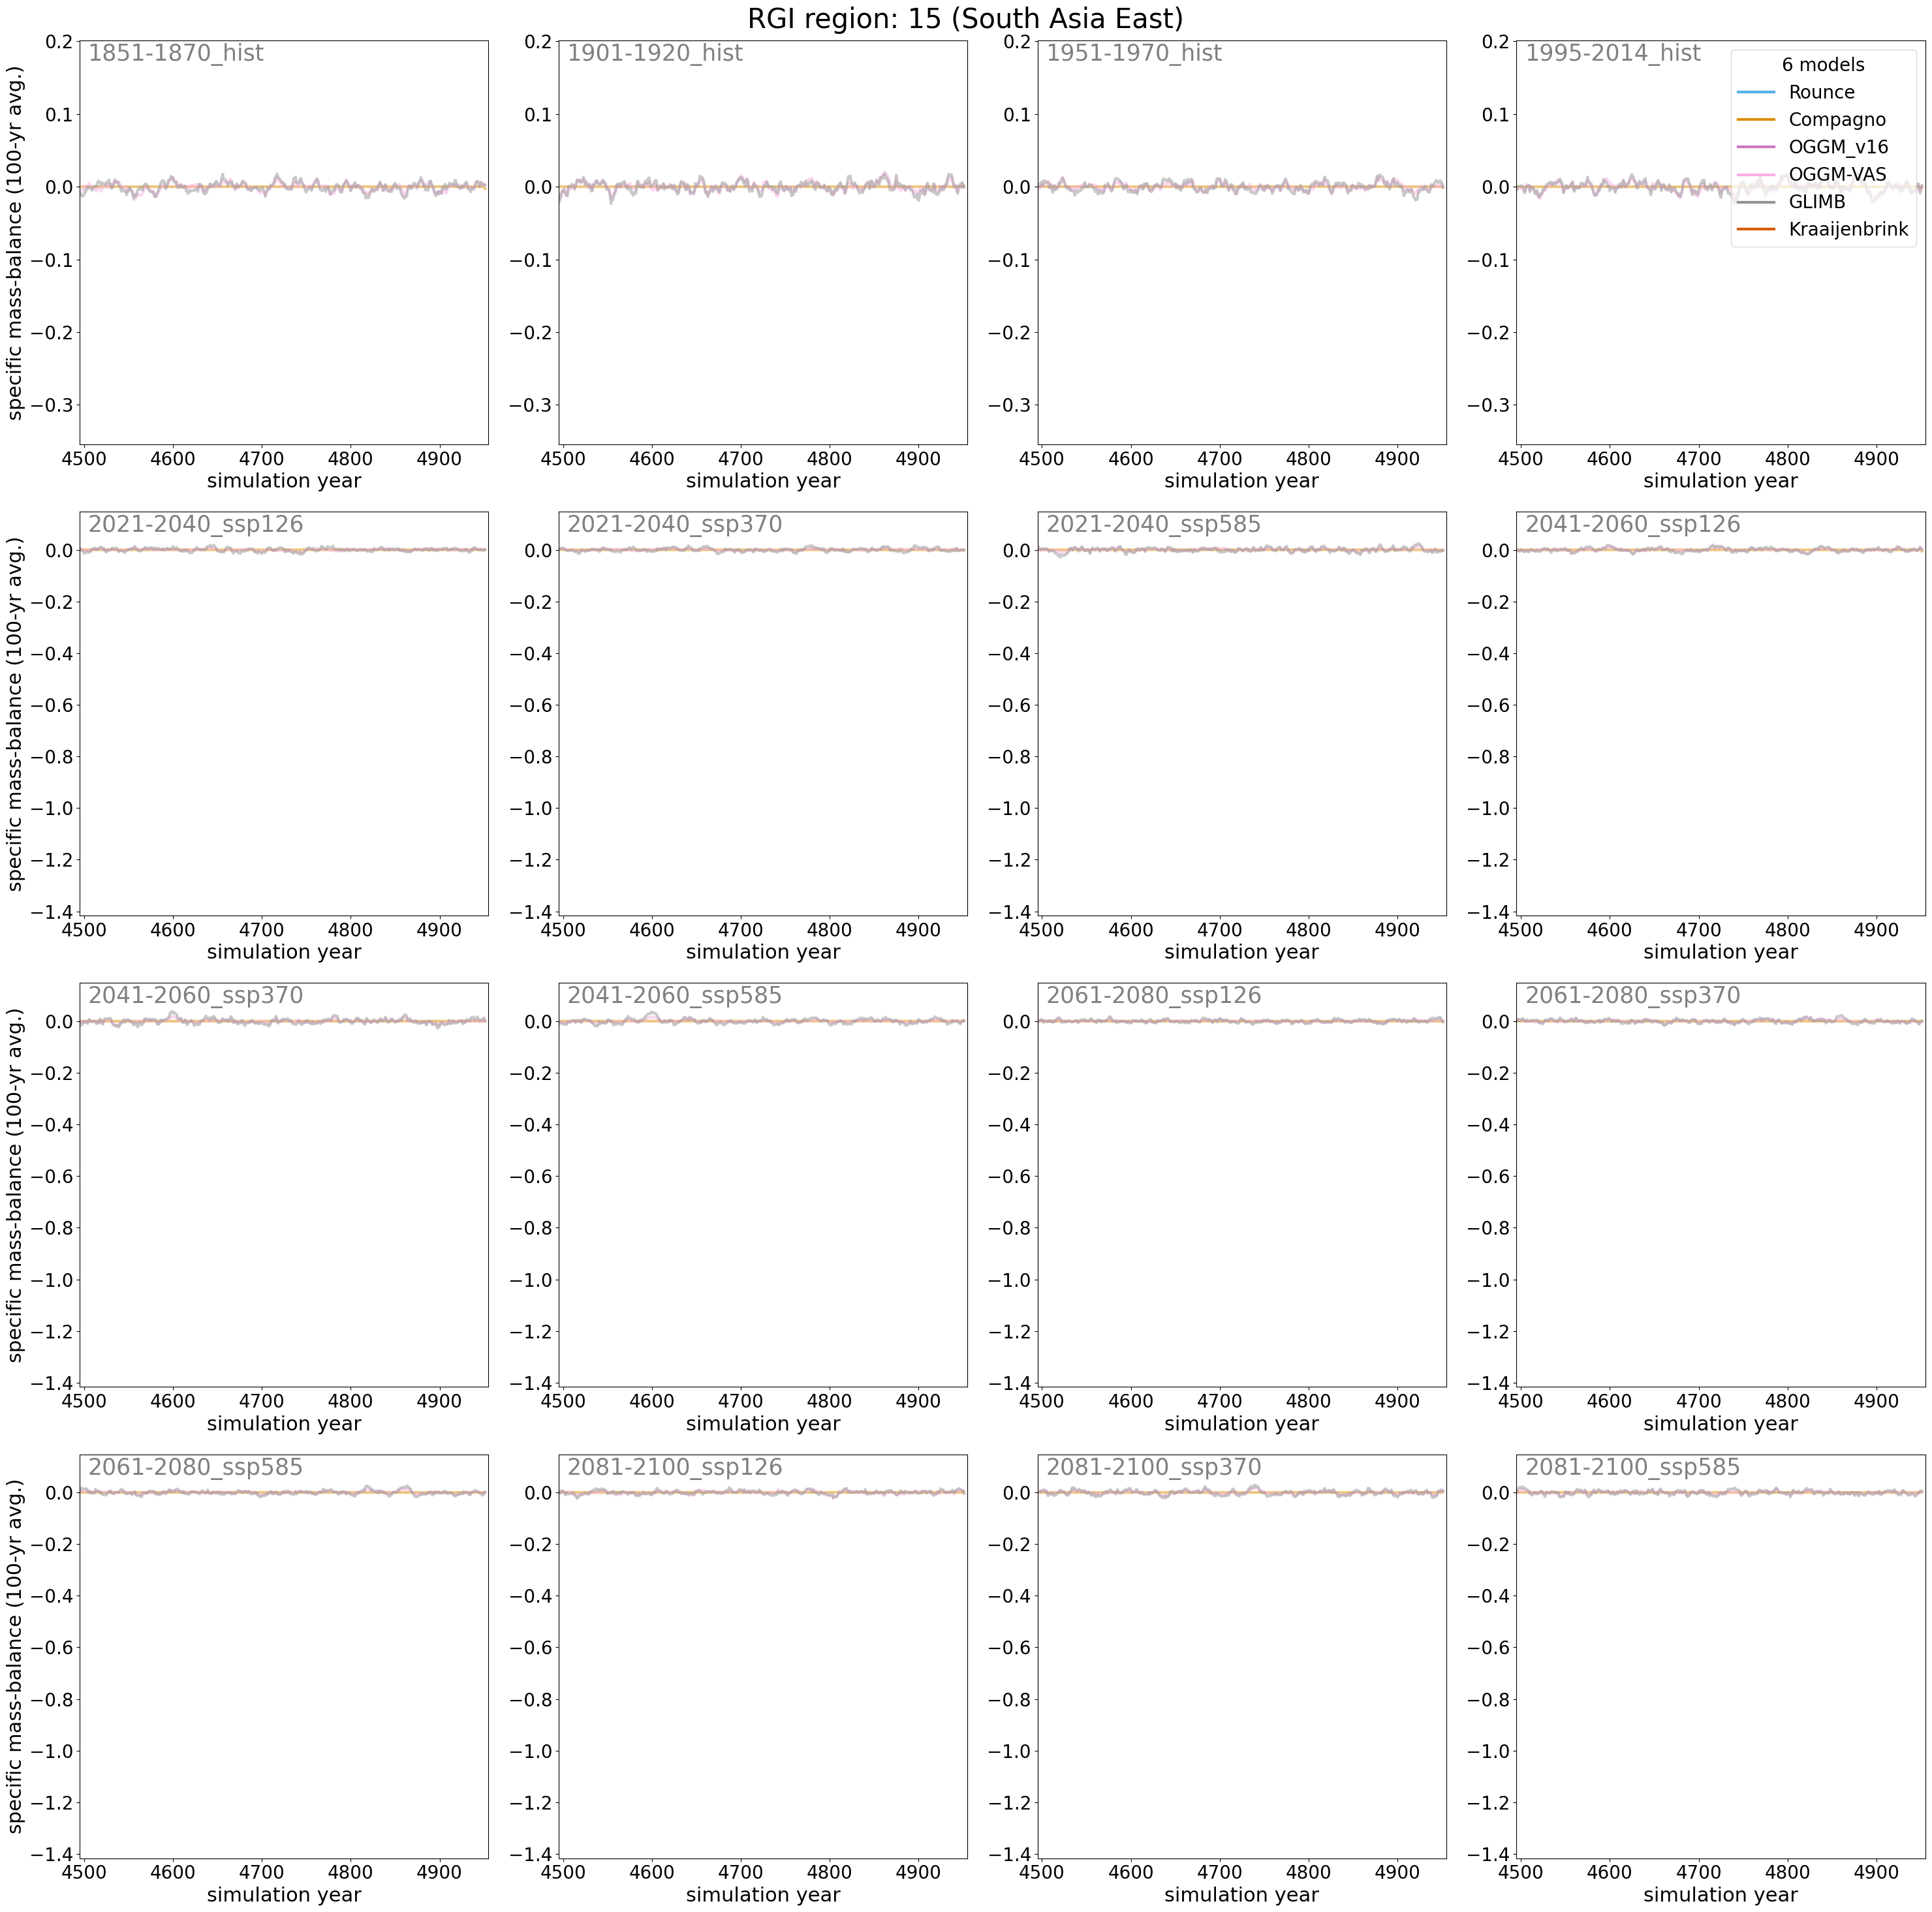

In [179]:
# just check the last 1000 years 
ls_l = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 1, 1, 1))]
#for anonym in ['', '_anonym']:
#for rgi_reg in ['11']:
#for rgi_reg in rgi_regs:
rgi_reg = '15'
axs = []
anonym = ''
plt.figure(figsize=(30,30))
for j,period_scenario in enumerate(ds_specific_mb.period_scenario):
    if j==0 or j==4:
        ax0=plt.subplot(4,4,j+1)
        ax = ax0
    else:
        ax=plt.subplot(4,4,j+1,sharey=ax0)
    axs.append(ax)
    for ls,gcm in zip([ls_l[0]],[ds_specific_mb.gcm[0]]):
        pd_reg_spec_mb_sel = ds_specific_mb_roll.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).to_dataframe('specific_mb').reset_index()
        pd_reg_spec_mb_sel = pd_reg_spec_mb_sel.dropna()

        # get  regional models and correct color, anonym model number 
        # to  get a legend with only the models of that region... 
        models_reg = pd_reg_spec_mb_sel.model_author.unique()
        dict_model_col_reg = {}
        list_reg_model_anonym = []
        for h, p in zip(hue_order,pal_models):
            if h in models_reg:
                dict_model_col_reg[h]= p
                list_reg_model_anonym.append(model_order_anonymous[h])

        if ls == 'solid' and j==3:
            sns.lineplot(x='simulation_year', data=pd_reg_spec_mb_sel, y='specific_mb',
                     hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax, alpha = 0.5)
            _leg = ax.get_legend()
            handles, labels = ax.get_legend_handles_labels()
            _leg.remove()
            n = len(models_reg)
            if anonym:
                leg = ax.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7)
            else:
                leg = ax.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
            for legobj in leg.legendHandles:
                legobj.set_linewidth(3.0)
            leg.set_zorder = 2.5
        else:
            sns.lineplot(x='simulation_year', data=pd_reg_spec_mb_sel, y='specific_mb',
                     hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax, alpha = 0.5)
        if j in [0,4,8,12]:
            ax.set_ylabel('specific mass-balance (100-yr avg.)', fontsize=22)
        else:
            ax.set_ylabel('')
        ax.set_xlabel('simulation year', fontsize=22)


    if j==3:
        minip, maxip = ax.get_ylim()
    elif j==15:
        minif, maxif = ax.get_ylim()

    ax.set_xlim([4495,4955])            

    #if j<4:
    #    ax2.set_ylim([minip*rel,maxip*rel])
    #else:
    #    ax2.set_ylim([minif*rel,maxif*rel])

    ax.text(0.02,0.95, str(period_scenario.values), color='grey', 
            fontsize=25, transform=ax.transAxes, zorder=6)

reg = d_reg_num_name[rgi_reg]
plt.suptitle(f'RGI region: {rgi_reg} ({reg})', fontsize=30)
plt.tight_layout()

plt.savefig(f'figures/1_overview_timeseries_plots/spec_mb_time_series_rgi_reg{rgi_reg}{anonym}_only_gfdl-esm4_last_yrs.png')
#plt.close()

- e.g. in RGI04: GloGEMFlow has a non-zero positive MB from 4500 till the end for some experiments, similarly in one experiment in RGI06 ...
- James very variable in terms of specific mass balance 
- are they correlating between the different models???

- old: same plot again without UKESM

In [ ]:
old = False
if old:
    ls_l = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 1, 1, 1))]

    for rgi_reg in rgi_regs:
        axs = []
        plt.figure(figsize=(30,40))
        for j,period_scenario in enumerate(ds_reg_models.period_scenario):
            if j==0 or j==4:
                ax0=plt.subplot(4,4,j+1)
                ax = ax0
            else:
                ax=plt.subplot(4,4,j+1,sharey=ax0)
            axs.append(ax)
            for ls,gcm in zip(ls_l,['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']):
                pd_reg_vol_sel = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).volume_m3.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (km³)'] = pd_reg_vol_sel['volume_m3']/1e9
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel.loc[pd_reg_vol_sel.rgi_reg==rgi_reg], y='volume (km³)',
                             hue='model_author', hue_order=hue_order, palette=pal_models, ls=ls, legend='brief', lw=3, ax=ax)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel.loc[pd_reg_vol_sel.rgi_reg==rgi_reg], y='volume (km³)',
                             hue='model_author', hue_order=hue_order, palette=pal_models, ls=ls, legend=False, lw=3, ax=ax)
                if j in [0,4,8,12]:
                    ax.set_ylabel('volume (km³)', fontsize=22)
                else:
                    ax.set_ylabel('')
                ax.set_xlabel('simulation year', fontsize=22)
                if ls == 'solid' and j==3: 
                    leg = ax.get_legend()
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                #leg.set_bbox_to_anchor([1,1])
            if j==3:
                minip, maxip = ax.get_ylim()
            elif j==15:
                minif, maxif = ax.get_ylim()

            ax.set_title(str(period_scenario.values))
            ax.set_xlim([-100,5100])

        for j,period_scenario in enumerate(ds_reg_models.period_scenario):
            ax = axs[j]
            ax2 = ax.twinx()
            for ls,gcm in zip(ls_l, ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']):
                _ref = 100*ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).volume_m3/ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).volume_m3.sel(simulation_year=0)
                pd_reg_vol_sel = _ref.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (relative to initial state, in %)'] = pd_reg_vol_sel['volume_m3']
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel.loc[pd_reg_vol_sel.rgi_reg==rgi_reg], 
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=hue_order, palette=pal_models, ls=ls, legend='brief', lw=3, ax=ax2)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel.loc[pd_reg_vol_sel.rgi_reg==rgi_reg], 
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=hue_order, palette=pal_models, ls=ls, legend=False, lw=3, ax=ax2)
                if j in [3,7,11,15]:
                    ax2.set_ylabel('volume (relative to initial state, in %)', fontsize=22)
                else:
                    ax2.set_ylabel('')

            rel = 100*1e9/ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).sel(simulation_year=0).volume_m3
            rel = rel.dropna(dim='model_author')
            np.testing.assert_allclose(rel[0], rel)
            rel = rel[0].values

            if j<4:
                ax2.set_ylim([minip*rel,maxip*rel])
            else:
                ax2.set_ylim([minif*rel,maxif*rel])


        reg = d_reg_num_name[rgi_reg]
        plt.suptitle(f'RGI region: {rgi_reg} ({reg})')
        plt.tight_layout()

        plt.savefig(f'/home/www/lschuster/glacierMIP3_analysis/analysis_2023_03/no_ukesm/vol_time_series_rgi_reg{rgi_reg}.pdf')
        plt.close()